In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_california_housing

In [2]:
california=fetch_california_housing()
df=pd.DataFrame(california.data,columns=california.feature_names)
df["Target"]=california.target

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [4]:
data=torch.from_numpy(df.values).float()
x=data[:,:-1]
y=data[:,-1:]

print(x.size(),y.size())

torch.Size([20640, 8]) torch.Size([20640, 1])


In [5]:
# Train / Valid / Test ratio
ratios=[.6, .2, .2]

In [6]:
train_cnt=int(data.size(0)*ratios[0])
valid_cnt=int(data.size(0)*ratios[1])
test_cnt=data.size(0)-train_cnt-valid_cnt
cnts=[train_cnt,valid_cnt,test_cnt]

print("Train %d / Valid %d / Test %d samples." %(train_cnt,valid_cnt,test_cnt))

Train 12384 / Valid 4128 / Test 4128 samples.


In [7]:
# Shuffle before split.
indices=torch.randperm(data.size(0))
x=torch.index_select(x,dim=0,index=indices)
y=torch.index_select(y,dim=0,index=indices)

# Split train, valid and test set with each count.
x=list(x.split(cnts,dim=0))
y=y.split(cnts,dim=0)

for x_i,y_i in zip(x,y):
    print(x_i.size(),y_i.size())

torch.Size([12384, 8]) torch.Size([12384, 1])
torch.Size([4128, 8]) torch.Size([4128, 1])
torch.Size([4128, 8]) torch.Size([4128, 1])


In [8]:
scaler=StandardScaler()
scaler.fit(x[0].numpy())

x[0]=torch.from_numpy(scaler.transform(x[0].numpy())).float()
x[1]=torch.from_numpy(scaler.transform(x[1].numpy())).float()
x[2]=torch.from_numpy(scaler.transform(x[2].numpy())).float()

In [9]:
model=nn.Sequential(
    nn.Linear(x[0].size(-1),6),
    nn.LeakyReLU(),
    nn.Linear(6,5),
    nn.LeakyReLU(),
    nn.Linear(5,4),
    nn.LeakyReLU(),
    nn.Linear(4,3),
    nn.LeakyReLU(),
    nn.Linear(3,y[0].size(-1)),
)

optimizer=optim.Adam(model.parameters())

In [10]:
n_epochs=4000
batch_size=256
print_interval=100

In [11]:
from copy import deepcopy

lowest_loss=np.inf
best_model=None

early_stop=100
lowest_epoch=np.inf

In [12]:
train_history,valid_history=[],[]

for i in range(n_epochs):
    # Shuffle before mini-batch split.
    indices=torch.randperm(x[0].size(0))
    x_=torch.index_select(x[0],dim=0,index=indices)
    y_=torch.index_select(y[0],dim=0,index=indices)
    
    x_=x_.split(batch_size,dim=0)
    y_=y_.split(batch_size,dim=0)
    
    train_loss,valid_loss=0,0
    y_hat=[]
    
    for x_i,y_i in zip(x_,y_):
        y_hat_i=model(x_i)
        loss=F.mse_loss(y_hat_i,y_i)
        
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()
        train_loss+=float(loss)
        
    train_loss=train_loss/len(x_)
    
    with torch.no_grad():
        x_=x[1].split(batch_size,dim=0)
        y_=y[1].split(batch_size,dim=0)
        
        valid_loss=0
        
        for x_i,y_i in zip(x_,y_):
            y_hat_i=model(x_i)
            loss=F.mse_loss(y_hat_i,y_i)
            
            valid_loss+=loss
            
            y_hat+=[y_hat_i]
            
    valid_loss=valid_loss/len(x_)
    
    train_history+=[train_loss]
    valid_history+=[valid_loss]
    
    if (i+1)%print_interval==0:
        print('Epoch %d: train loss=%.4f valid_loss=%.4f lowest_loss=%.4f' %
    (
            i+1,
            train_loss,
            valid_loss,
            lowest_loss,
        ))
    
    if valid_loss<=lowest_loss:
        lowest_loss=valid_loss
        lowest_epoch=i
        
        best_model=deepcopy(model.state_dict())
    else:
        if early_stop>0 and lowest_epoch+early_stop<i+1:
            print("There is no improvement during last %d epochs." %early_stop)
            break

print("The best validation loss from epoch %d: %.4f" %(lowest_epoch+1,lowest_loss))

# Load best epoch's model.
model.load_state_dict(best_model)

Epoch 100: train loss=0.3467 valid_loss=0.3583 lowest_loss=0.3577
Epoch 200: train loss=0.3251 valid_loss=0.3370 lowest_loss=0.3359
Epoch 300: train loss=0.3152 valid_loss=0.3275 lowest_loss=0.3276
Epoch 400: train loss=0.3111 valid_loss=0.3237 lowest_loss=0.3229
Epoch 500: train loss=0.3116 valid_loss=0.3251 lowest_loss=0.3218
There is no improvement during last 100 epochs.
The best validation loss from epoch 454: 0.3218


<All keys matched successfully>

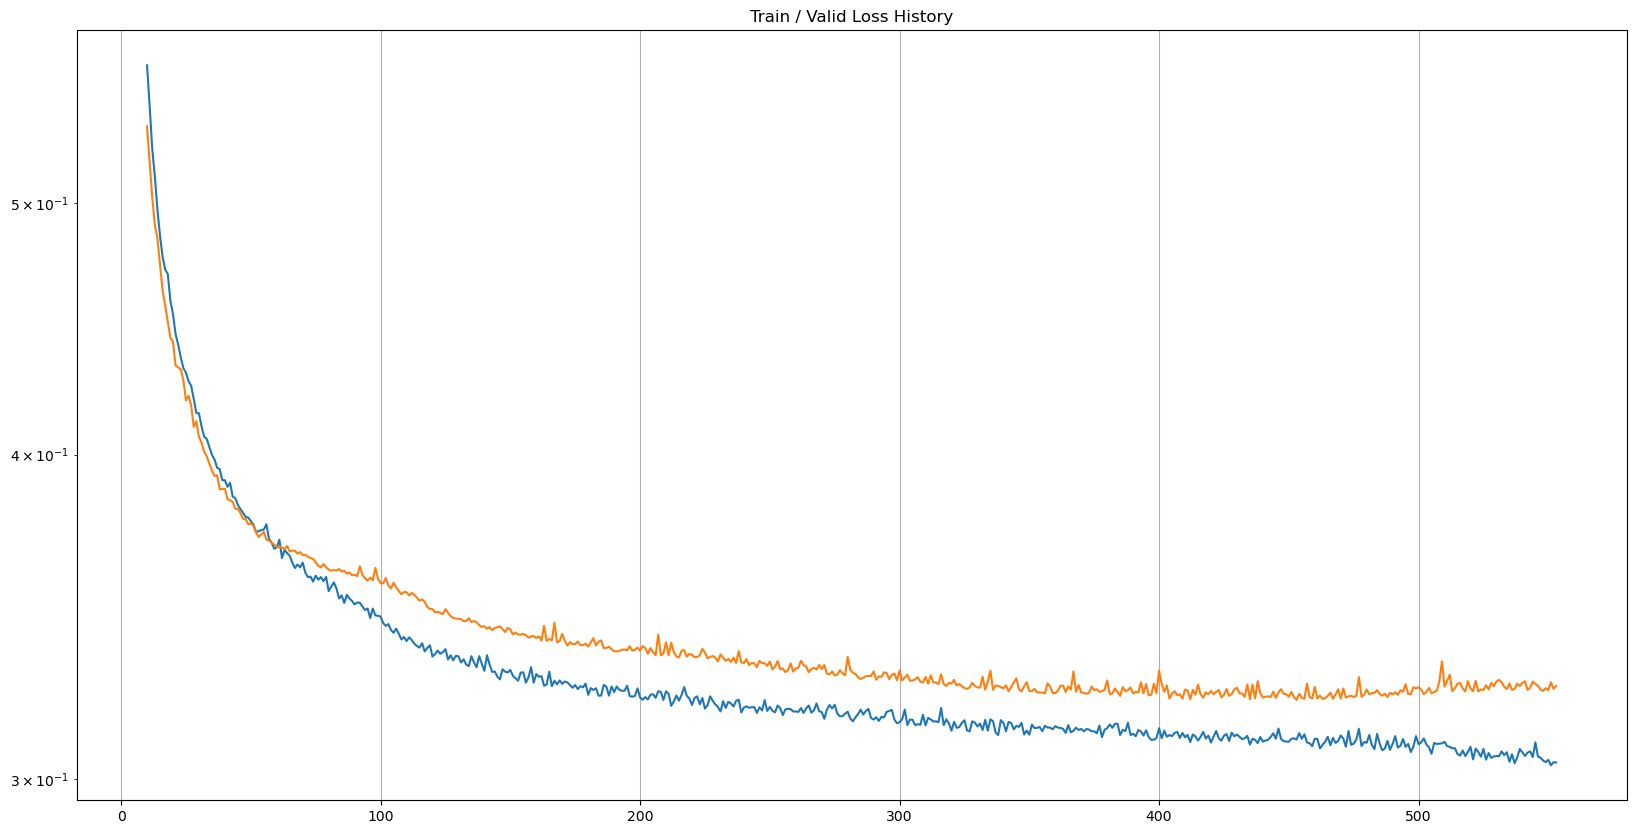

In [13]:
plot_from=10

plt.figure(figsize=(20,10))
plt.grid(True)
plt.title("Train / Valid Loss History")
plt.plot(
    range(plot_from,len(train_history)),train_history[plot_from:],
    range(plot_from,len(valid_history)),valid_history[plot_from:],
)
plt.yscale('log')
plt.show()

In [15]:
test_loss=0
y_hat=[]

with torch.no_grad():
    x_=x[2].split(batch_size,dim=0)
    y_=y[2].split(batch_size,dim=0)
    
    for x_i,y_i in zip(x_,y_):
        y_hat_i=model(x_i)
        loss=F.mse_loss(y_hat_i,y_i)
        
        test_loss+=loss
        y_hat+=[y_hat_i]
        
test_loss=test_loss/len(x_)
y_hat=torch.cat(y_hat,dim=0)

sorted_history=sorted(zip(train_history,valid_history),key=lambda x: x[1])

print("Train loss: %.4f" % sorted_history[0][0])
print("Valid loss: %.4f" % sorted_history[0][1])
print("Test loss: %.4f" % test_loss)

Train loss: 0.3107
Valid loss: 0.3218
Test loss: 0.3440


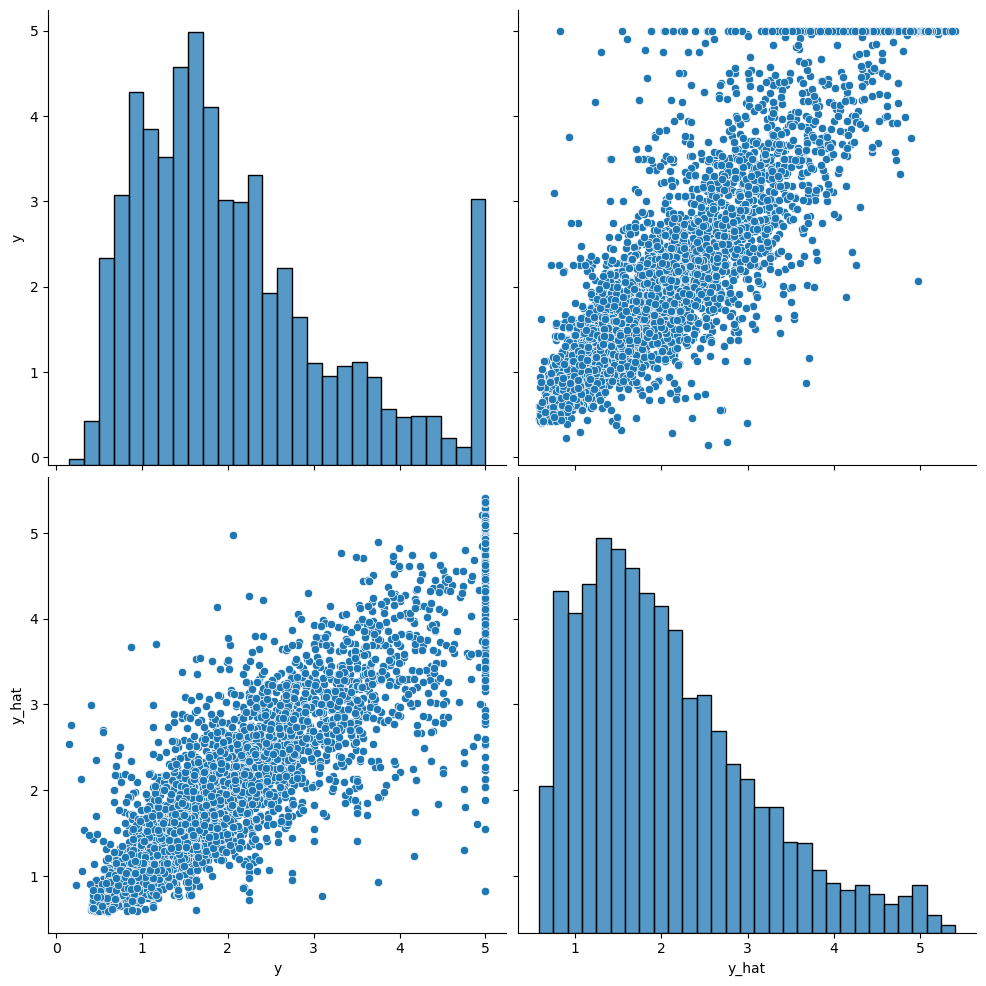

In [16]:
df=pd.DataFrame(torch.cat([y[2],y_hat],dim=1).detach().numpy(),columns=["y","y_hat"])

sns.pairplot(df,height=5)
plt.show()